In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# Etapas iniciais - importando banco de dados e criando dataframes

In [2]:
#hide
from fastai.vision.all import *
path = Path('/kaggle/input/retinal-disease-classification')

# path = Path('/kaggle/input/retinal-disease-classification'): abre o banco de dados que eu adicionei (já existente no Kaggle).

In [3]:
Path.BASE_PATH = path

# "Considere a pasta path como a base para mostrar todos os caminhos relativos daqui pra frente."

Mostrando caminhos de treino e validação.

In [4]:
(path/'Training_Set/Training_Set').ls()

(#2) [Path('Training_Set/Training_Set/RFMiD_Training_Labels.csv'),Path('Training_Set/Training_Set/Training')]

In [5]:
(path/'Evaluation_Set/Evaluation_Set').ls()

(#2) [Path('Evaluation_Set/Evaluation_Set/Validation'),Path('Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')]

Definindo dataframes de treino e validação.

In [6]:
df_train = pd.read_csv(path/'Training_Set/Training_Set/RFMiD_Training_Labels.csv')
df_valid = pd.read_csv(path/'Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')

Mostrando roporção de individuos sem (0) e com (1) retinopatia diabética nos dataframes de treino e validação.

In [7]:
df_train['DR'].value_counts(normalize=True)

DR
0    0.804167
1    0.195833
Name: proportion, dtype: float64

In [8]:
df_valid['DR'].value_counts(normalize=True)

DR
0    0.79375
1    0.20625
Name: proportion, dtype: float64

# Criando os datablock e dataloaders

Criando nova variável que de qual dataset aquela linha é (treino ou validação), para diferenciar na hora que juntar tudo

In [9]:
df_train['src'] = 'train'
df_valid['src'] = 'valid'

Criando nova variável em ambos os datasets que é o número da id + png, para que possamos localizar os arquivos de imagem usando path.

In [10]:
df_train['fname'] = df_train['ID'].astype(str) + '.png'
df_valid['fname'] = df_valid['ID'].astype(str) + '.png'

Combinando os dois dataframes.

In [12]:
df_combined = pd.concat([df_train, df_valid], ignore_index=True)
df_combined['is_valid'] = df_combined['src'] == 'valid'

# pd.concat(...): empilha os dois DataFrames, um embaixo do outro.
# ignore_index=True: reorganiza o índice para ser contínuo (0, 1, 2, ...), o que evita conflitos de índice duplicado.

# df_combined['is_valid'] = df_combined['src'] == 'valid'
# Cria uma coluna booleana: True se a linha veio do df_valid, False se veio do df_train.

Mostrando primeiras 5 colunas do dataframe - todas do dataframe de treino.

In [14]:
df_combined.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,src,fname,is_valid
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train,1.png,False
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train,2.png,False
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train,3.png,False
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train,4.png,False
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train,5.png,False


Mostrando últimas 5 colunas do dataset - todas do dataframe de validação.

In [15]:
df_combined.tail()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,src,fname,is_valid
2555,636,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,valid,636.png,True
2556,637,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,valid,637.png,True
2557,638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,valid,638.png,True
2558,639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,valid,639.png,True
2559,640,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,valid,640.png,True


Criando função para carregar imagens do dataframe de treino e validação.

In [16]:
def get_x(r):
    if r['src'] == 'train':
        return path/'Training_Set/Training_Set/Training'/r['fname']
    else:
        return path/'Evaluation_Set/Evaluation_Set/Validation'/r['fname']

# Ela recebe uma linha do DataFrame (r)
# Olha o valor da coluna src:
# Se for 'train': usa o caminho da pasta de treino
# Se for 'valid': usa o caminho da pasta de validação
# Em ambos os casos, ela retorna um Path completo para o arquivo de imagem


In [17]:
test_path = get_x(df_combined.iloc[0])
print(test_path)             # mostra o caminho gerado
print(test_path.exists())    # verifica se o arquivo realmente existe

/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training/1.png
True


In [18]:
test_path = get_x(df_combined.iloc[2556])
print(test_path)             # mostra o caminho gerado
print(test_path.exists()) # verifica se o arquivo realmente existe

/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation/637.png
True


Criando função para definir as labels - retinopatia diabética (coluna DR do dataset)

In [19]:
df_combined['DR'] = df_combined['DR'].astype(str)
def get_y(r): return r['DR']

# Fazendo função para que o datablock possa carregar os labels

Criando splitter para definir datasets de validacao e treino

In [20]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

# df['is_valid']: Isso retorna uma Series booleana com True e False.
# ~df['is_valid']: O operador ~ (til) inverte os valores booleanos: True → False, False → True
# df.index[...]: Acessa os índices das linhas que satisfazem a condição (ex: treino ou validação).
# .tolist(): Converte os índices (que são objetos do tipo Index) em listas padrão Python, como [0, 1, 5, 8]

Criando o datablock.

In [21]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=splitter,
    get_x=get_x, 
    get_y=get_y,
    item_tfms=Resize(224, method='pad', pad_mode='zeros')
)

Criando os dataloaders.

In [22]:
dls = dblock.dataloaders(df_combined)

Mostrando algumas imagens e com seus labels do batch.

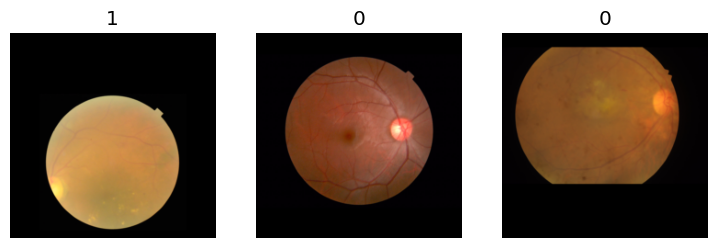

In [23]:
dls.show_batch(nrows=1, ncols=3)

# Redes neurais - Resnet 18

## Rede neural inicial

Fazendo fine tuning de Rede Neural Convolucional pré-treinada no Imagenet - Resnet 18

In [24]:
learn = vision_learner(dls, resnet18, metrics=accuracy, error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.927153,0.556887,0.784375,03:13


epoch,train_loss,valid_loss,accuracy,time
0,0.598338,0.704918,0.721875,03:04
1,0.477694,0.340592,0.885938,03:06
2,0.360202,0.339716,0.885938,03:02


## Otimizando rede neural

Encontrando learning rate ideal para camadas que não foram pré-treinadas (head).

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


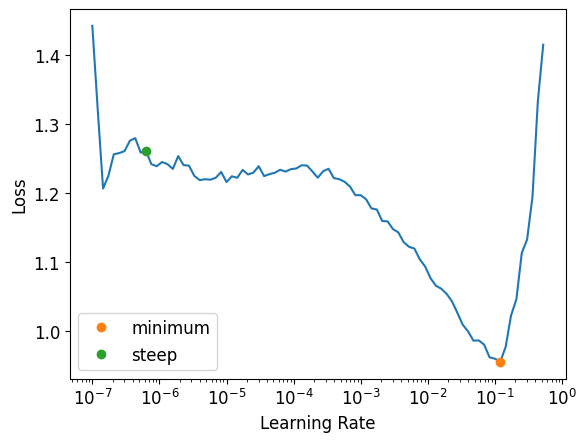

In [27]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

# lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
# Roda um mini-treino de poucos batches, testando vários learning rates diferentes, que vão crescendo de forma exponencial (de bem pequeno até grande),
# E mede a loss para cada learning rate,
# No final, plota um gráfico: Learning Rate vs Loss
# minimum: O learning rate onde a loss foi mínima durante o teste
# steep (recomendado): O learning rate onde a curva da loss teve a descida mais íngreme (ou seja, onde o gradiente da perda foi mais negativo)

In [28]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 6.31e-07


Treinando só as últimas camadas usando LR próximo do ideal. O steepest captado está em uma região quase plana, onde a loss ainda não caiu muito. Usar esse lr (∼1e-6) seria muito conservador, e o modelo aprenderia devagar. 1.2e-2 parece um ponto adequado.

In [29]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(2, 1.2e-2)

# O que é o One Cycle Policy?
# É uma estratégia de ajuste de learning rate durante o treino:

#Ele faz o learning rate:

# Subir gradualmente nas primeiras etapas (warm-up),

# Depois cair lentamente,

# Eventualmente chegando a valores muito pequenos no final do ciclo.

# Por que?
# Melhora a convergência: Ajuda a sair de mínimos locais
# Evita overfitting: Ao reduzir o LR no final, faz o modelo "assentar"
# Reduz tempo de treino	Muitas vezes atinge bom desempenho em menos épocas

# Nesse codigo ele treina apenas as cabeças (partes novas) do modelo, com o restante (pré-treinado) congelado.

epoch,train_loss,valid_loss,error_rate,time
0,0.803602,0.704300,0.301562,02:44
1,0.497524,0.391518,0.148438,02:41


Encontrando o learning rate ideal para camadas mais profundas (pré-treinadas).

SuggestedLRs(valley=2.511886486900039e-05)

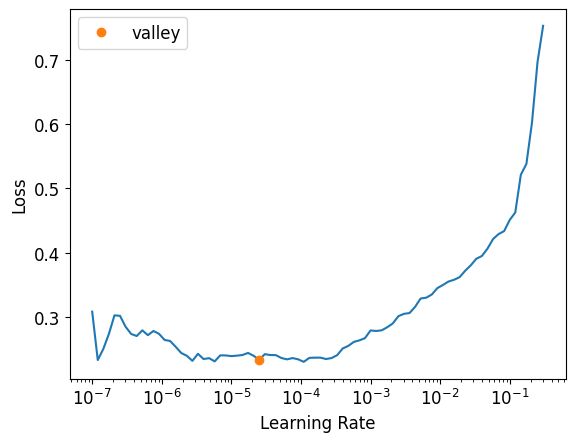

In [30]:
learn.unfreeze()
learn.lr_find()

# Antes: Apenas as últimas camadas (fully connected layers / head) estavam treináveis. Backbone (camadas convolucionais) estava congelado
# Agora: Todas as camadas da ResNet34 (incluindo as convolucionais pré-treinadas) ficam treináveis. Backbone agora pode ser ajustado (fine-tuning completo)

# Roda o lr.finda pra saber qual learning rate ideal nas camadas mais profundas.

# O "valley" (ou vale) é o ponto onde a perda (Loss) atinge o valor mais baixo antes de começar a subir de novo. É um ponto ideal entre ter a LR muito baixa (tempo longo de treinamento, overfitting) e perde muito a loss.
# A curva era ao contrário do modelo com pesos "virgens" (mais "burro"). Nesse caso, o modelo ja As camadas já estão com pesos bem razoáveis, sabe bastante coisa util, mesmo antes do fine tuning.
# Como a rede já está "boa", a loss começa baixa (porque os pesos já estão bem ajustados para visão em geral).
# Mas à medida que o learning rate aumenta, você começa a estragar os pesos (por updates muito agressivos),

Treinamento otimizado da Resnet 34, com learning rates ideais de acordo com profundidade das camadas e utilizando técnicas de fit one cycle e slices.

In [32]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(2, 1.2e-2)
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(2.5e-6,2.5e-5))

# learn = vision_learner(dls, resnet34, metrics=error_rate): Criou o learner
# learn.fit_one_cycle(2, 3e-3): Só a cabeça (últimas camadas) foi treinada primeiro com LR ideal.
# learn.unfreeze(): Liberou todas as camadas para treino (inclusive as convolucionais pré-treinadas)
# it_one_cycle(3, lr_max=slice(1e-6,1e-4)): Fez fine-tuning completo com learning rates diferentes (baseado no LR ideal): Camadas iniciais com LR menor (1e-6), camadas finais com LR maior (1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.722254,0.412718,0.887500,03:10
1,0.465082,0.310353,0.895312,03:08


epoch,train_loss,valid_loss,accuracy,time
0,0.237949,0.309818,0.895312,03:09
1,0.220854,0.303565,0.895312,03:09
2,0.206488,0.302454,0.895312,03:08


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

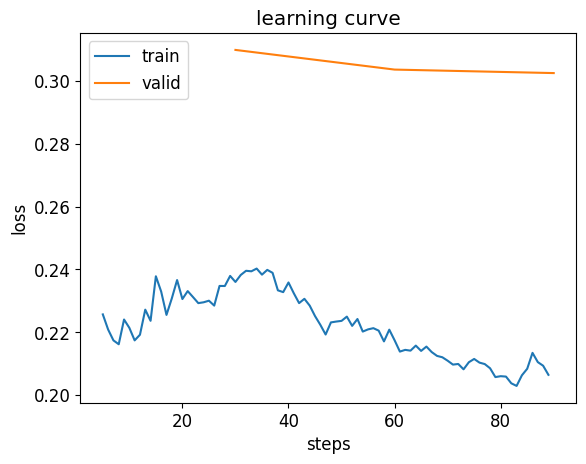

In [33]:
learn.recorder.plot_loss()

# Gráfico de loss ao longo das épocas de treinamento. 